# Lab 4

#### Joseph Bu

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import scipy.optimize
import h5py
import pandas as pd

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (15,10)

## Problem 1

### 1) Download the data from the course website (gammaray_lab4.h5), and import it into your working environment. The data has 4 columns and more than 25 million rows. The columns are time (in gps seconds), Solar phase (deg) showing the position of the sun relative to the orbit, Earth longitude (deg) giving the position of the spacecraft relative to the ground, and particle counts. Make a few plots, generally exploring your data and making sure you understand it. Give a high level description of the data features you see. Specifically comment on whether you see signal contamination in your data, and how you plan to build a background pdf().

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

In [3]:
d = {'Time':data[0], 'Solar Phase':data[1], 'Longitude':data[2], 'Particle Counts':data[3]}
df = pd.DataFrame(data=d)
df

,Time,Solar Phase,Longitude,Particle Counts
0,940680016.0,315.000000,45.000000,10.0
1,940680016.1,315.007112,45.006667,8.0
2,940680016.2,315.014225,45.013333,7.0
3,940680016.3,315.021337,45.020000,11.0
4,940680016.4,315.028449,45.026667,8.0
...,...,...,...,...
25919996,943272015.6,345.304884,44.973333,5.0
25919997,943272015.7,345.311996,44.980000,9.0
25919998,943272015.8,345.319109,44.986667,8.0
25919999,943272015.9,345.326221,44.993333,11.0


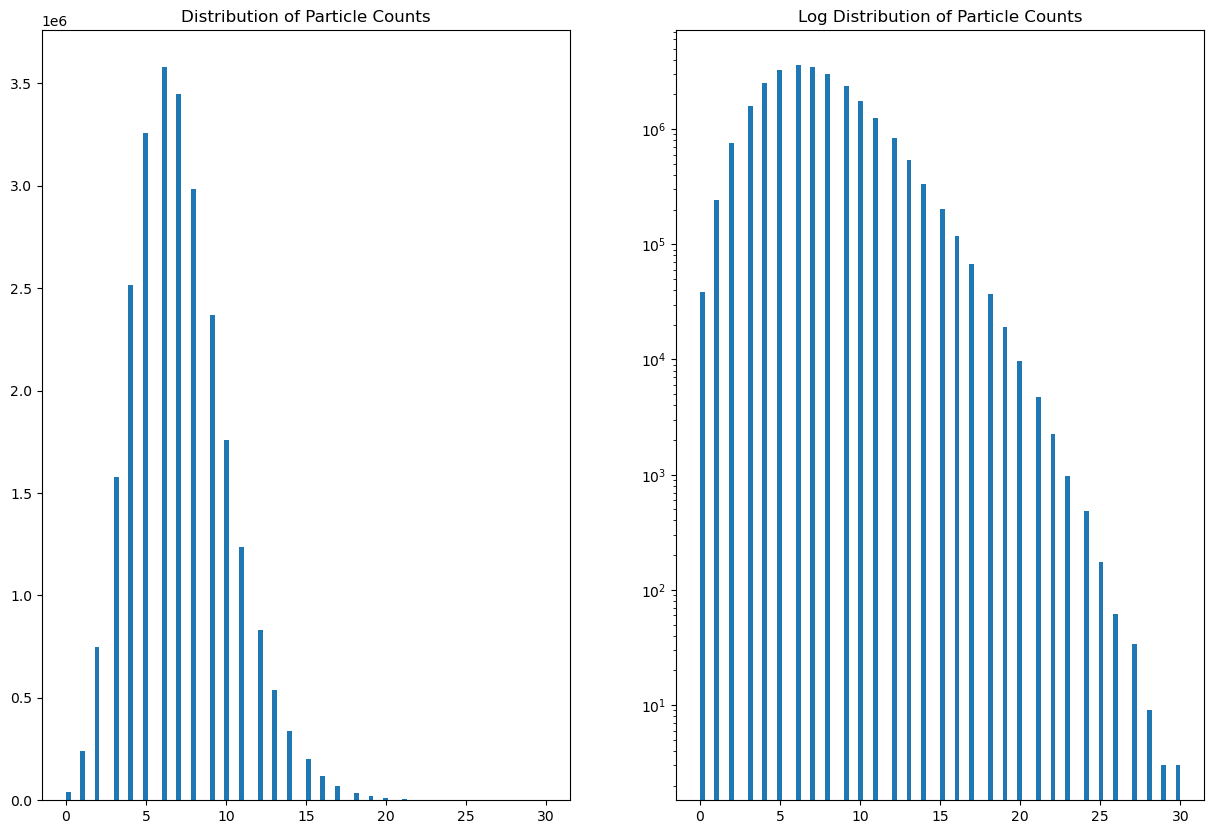

In [4]:
fig, ax = plt.subplots(1, 2)
ax[0].hist(df['Particle Counts'], bins=100)
ax[0].set_title('Distribution of Particle Counts')

ax[1].hist(df['Particle Counts'], bins=100)
ax[1].set_title('Log Distribution of Particle Counts')
plt.yscale('log')

So as we can see from the distributions of the Particle Counts we can see that it is clearly a Poisson Distribution. Overall, there doesn't seem to be too much signal contamination.

### 2) The background is not consistent across the dataset. Find and describe as accurately as you can how the background changes.

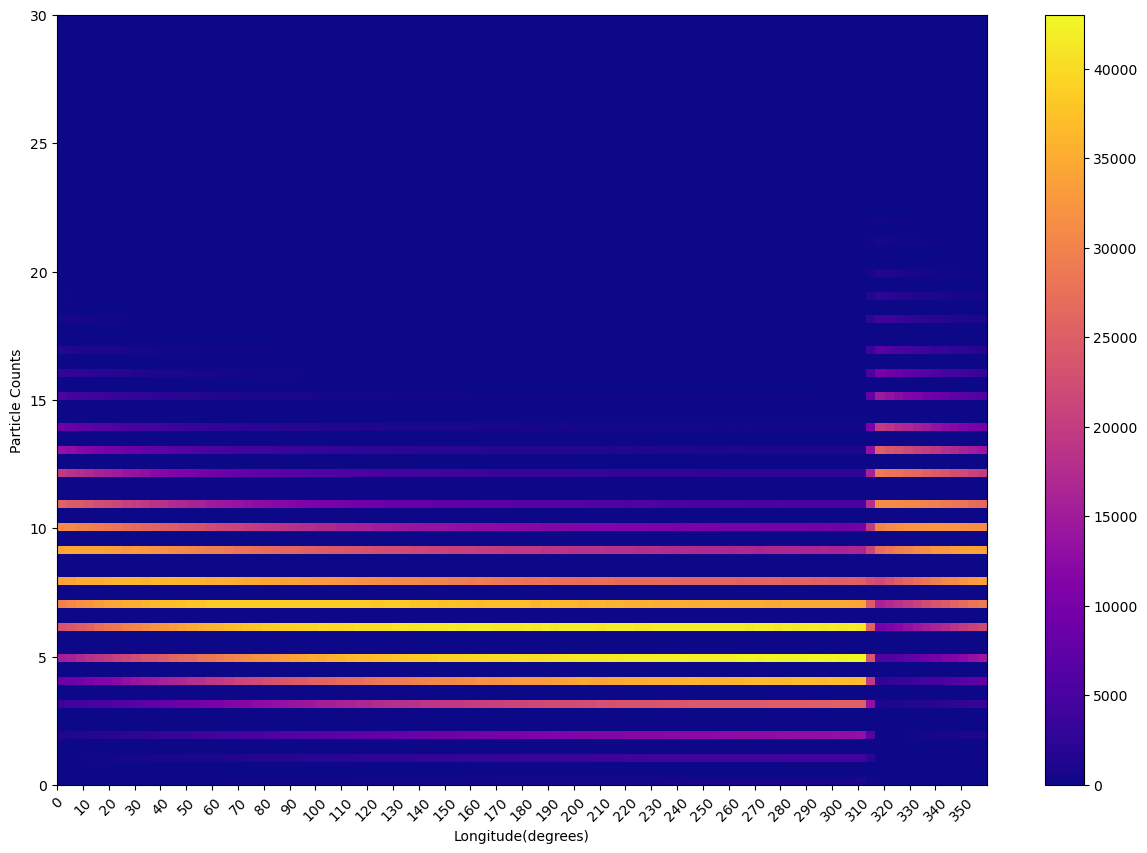

In [5]:
x = df['Longitude'] 
y = df['Particle Counts']
plt.hist2d(x, y, bins = 100, cmap=plt.cm.plasma)
plt.colorbar()
plt.xticks(np.arange(min(x), max(x), 10), rotation=45)
plt.xlabel('Longitude(degrees)')
plt.ylabel('Particle Counts')
plt.show()

### 3) Create a model for the background that includes time dependence, and explicitly compare your model to the data. How good is your model of the background?

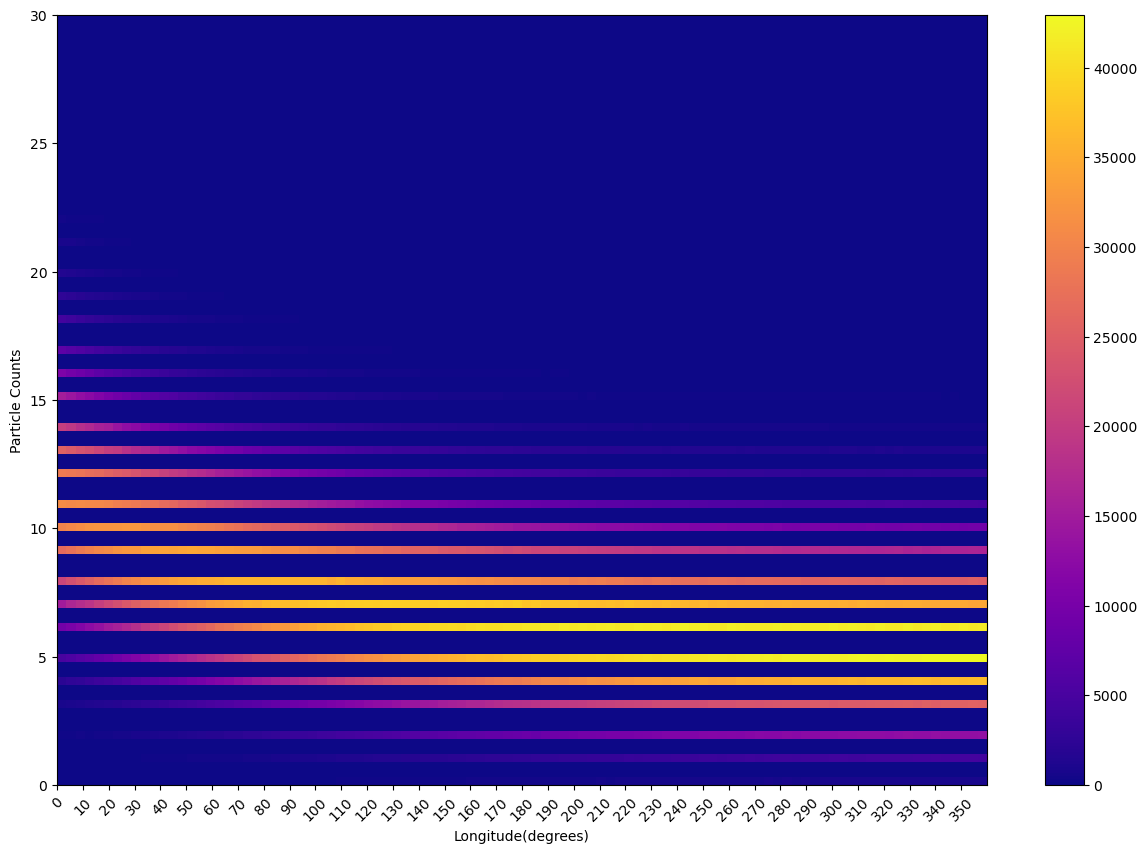

In [6]:
x_mod = (df['Longitude'] + 45) % 360
plt.hist2d(x_mod, y, bins = 100, cmap=plt.cm.plasma)
plt.colorbar()
plt.xticks(np.arange(min(x_mod), max(x_mod), 10), rotation=45)
plt.xlabel('Longitude(degrees)')
plt.ylabel('Particle Counts')
plt.show()

So after we fold the longitude we can see a pattern in the data. So now we take the mean of the particle counts and see if we can plot the curve or pattern we see.

In [8]:
mean = []
for i in range(54000): # 54000 = (num of ms in 90 min) / 100 ms
    temp = np.mean(df['Particle Counts'][i::54000])
    mean.append(temp)


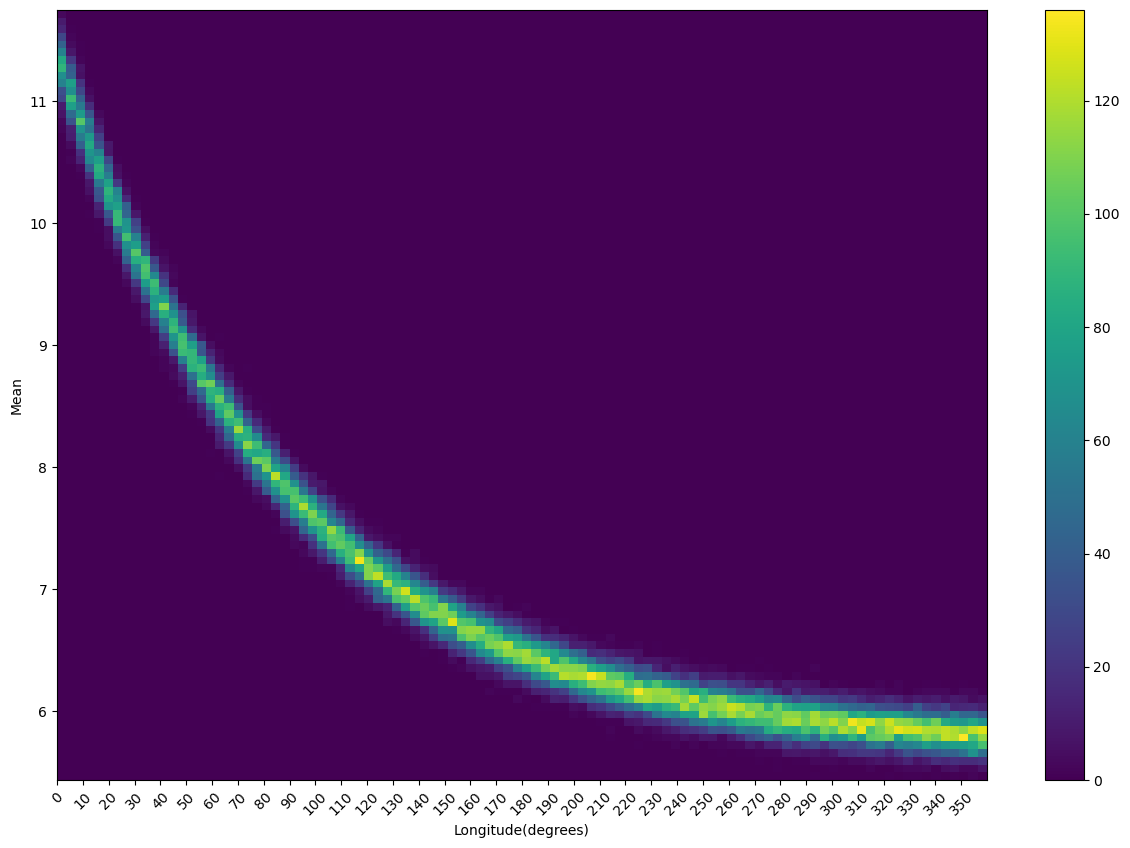

In [9]:
x_mean = (df['Longitude'][0:54000] + 45) % 360
plt.hist2d(x_mean, mean, bins=100)
plt.xticks(np.arange(min(x_mean), max(x_mean), 10), rotation=45)
plt.xlabel('Longitude(degrees)')
plt.ylabel('Mean')
plt.colorbar()
plt.show()

In [10]:
def monoExp(xs, m, t, b):
    return m * np.exp(-t * xs) + b

In [11]:
# perform the fit
x_cf = x_mean
y_cf = mean
p0 = (2000, .1, 50) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, x_cf, y_cf, p0)
m, t, b = params
sampleRate = 20_000 # Hz
tauSec = (1 / t) / sampleRate

# determine quality of the fit
squaredDiffs = np.square(y_cf - monoExp(x_cf, m, t, b))
squaredDiffsFromMean = np.square(y_cf - np.mean(y_cf))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")

# inspect the parameters
print(f"Y = {m} * e^(-{t} * x) + {b}")
print(f"Tau = {tauSec * 1e6} µs")

R² = 0.9930108417793986
Y = 5.694199543532884 * e^(-0.011098609799101204 * x) + 5.698320445130397
Tau = 4505.068734288608 µs


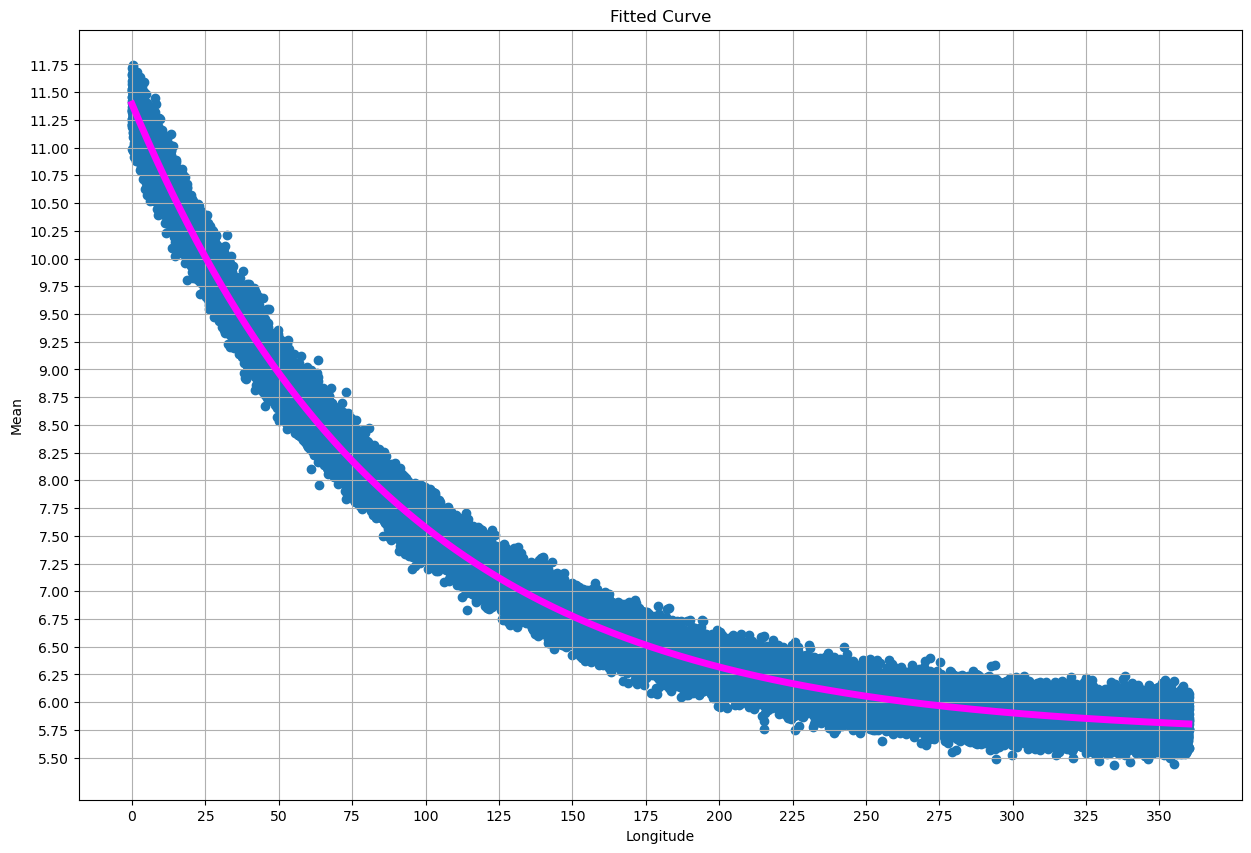

In [12]:
X = np.linspace(0, 360, num = len(mean))
Y = 5.694199543532884 * np.exp(-0.011098609799101204 * X) + 5.698320445130397 # this is our model
model = Y

plt.scatter(x_mean, mean)
plt.plot(X, model, color='fuchsia', linewidth=5)
plt.title('Fitted Curve')
plt.xlabel('Longitude')
plt.xticks(np.arange(0,360,25))
plt.ylabel('Mean')
plt.yticks(np.arange(5.5, 12, 0.25))
plt.grid()
plt.show()

Comparing model to data:

For a randomly chosen longitude, how does the data compare to a distribution generated from the mean value predicted by our model? So if longitude = 125, then our mean = 7.12

In [13]:
long = 125
k_model = np.arange(0, 18, 1)
test_mean = 7.12

In [14]:
poisson = stats.poisson.pmf(k_model, test_mean)
test_counts = df[df['Longitude'] == long]['Particle Counts']

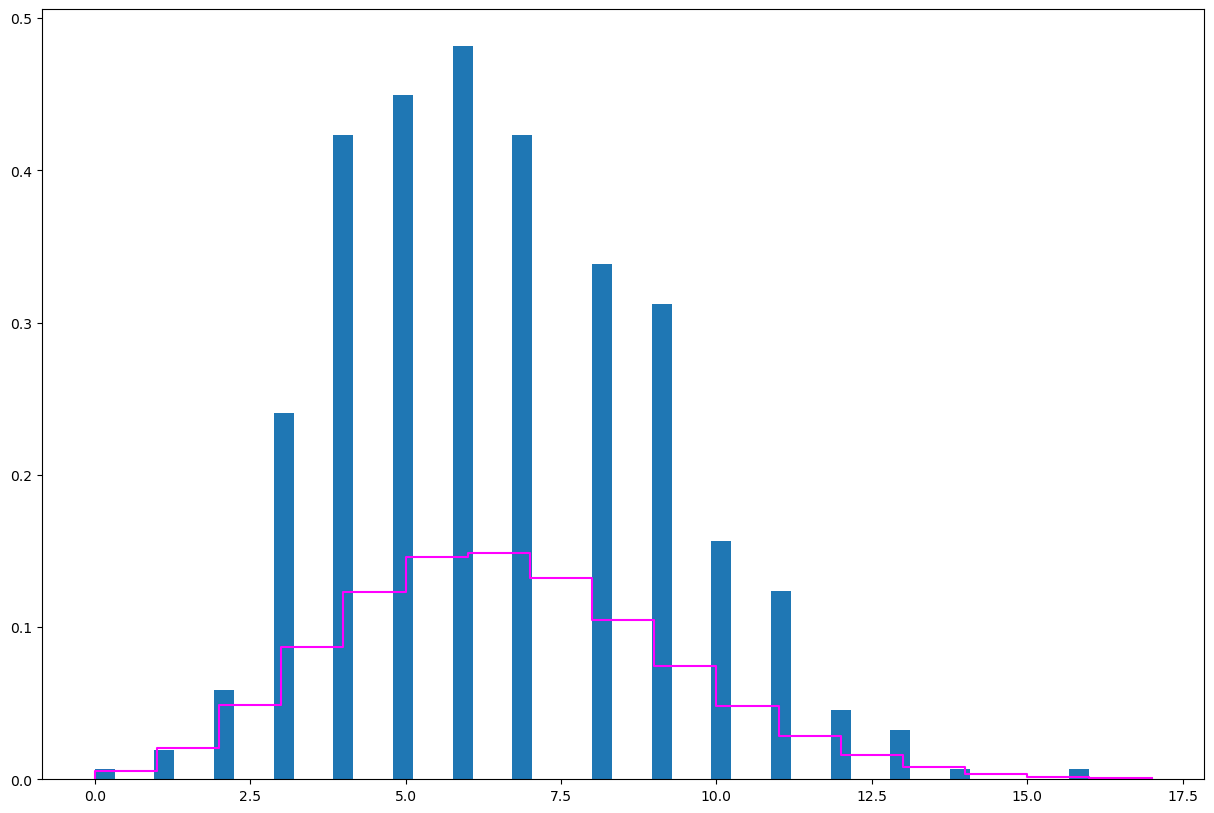

In [15]:
plt.hist(test_counts, bins=50, density=True)
plt.step(k_model, poisson, color='fuchsia')
plt.show()

So we can see our model predicts and produces a Poisson distrubtion with a mean value relatively consistent to the data. We can see that the model doesn't predict the correct number of counts and has a much lower number of counts than the actual data.

#### 4) Because the background varies, your discovery sensitivity threshold (how many particles you would need to see) also varies. What is the '5-sigma' threshold for a 100 millisecond GRB at different times?

In [16]:
five_sig = 1/3.5e6

In [17]:
long1 = 25
mean1 = 10
stats.poisson.isf(five_sig, mean1)

29.0

For 25 degrees longitude, our 5 sigma threshold is 29.0

In [18]:
long2 = 75
mean2 = 8.2
stats.poisson.isf(five_sig, mean2)

26.0

For 75 degrees longitude, our 5 sigma threshold is 26.0

In [19]:
long3 = 150
mean3 = 6.75
stats.poisson.isf(five_sig, mean3)

23.0

For 150 degrees longitude, our 5 sigma threshold is 23.0

In [20]:
long4 = 325
mean4 = 6.12
stats.poisson.isf(five_sig, mean4)

22.0

For 325 degrees longitude our 5 sigma threshold is 22.0

## Problem 2

In this problem we are going to look at a stack of telescope images (again simulated). We have 10 images, but you and your lab partner will be looking for different signals. One of you will be looking for the faintest stars, while the other will be looking for a transient (something like a super novae that only appears in one image). Flip a coin to determine which of you is pursuing which question.

#### 1) Download the data from images.h5. This is a stack of 10 square images, each 200 pixels on a side.

In [21]:
images = h5py.File('images.h5', 'r')
images.keys()

<KeysViewHDF5 ['image1', 'imagestack']>

In [22]:
img_set = images['imagestack']
img_data = np.array(img_set)

#### 2) Explore the data. Is there signal contamination? Is the background time dependent? Is it consistent spatially? Develop a plan to calculate your background pdf().

In [23]:
np.shape(img_data)

(200, 200, 10)

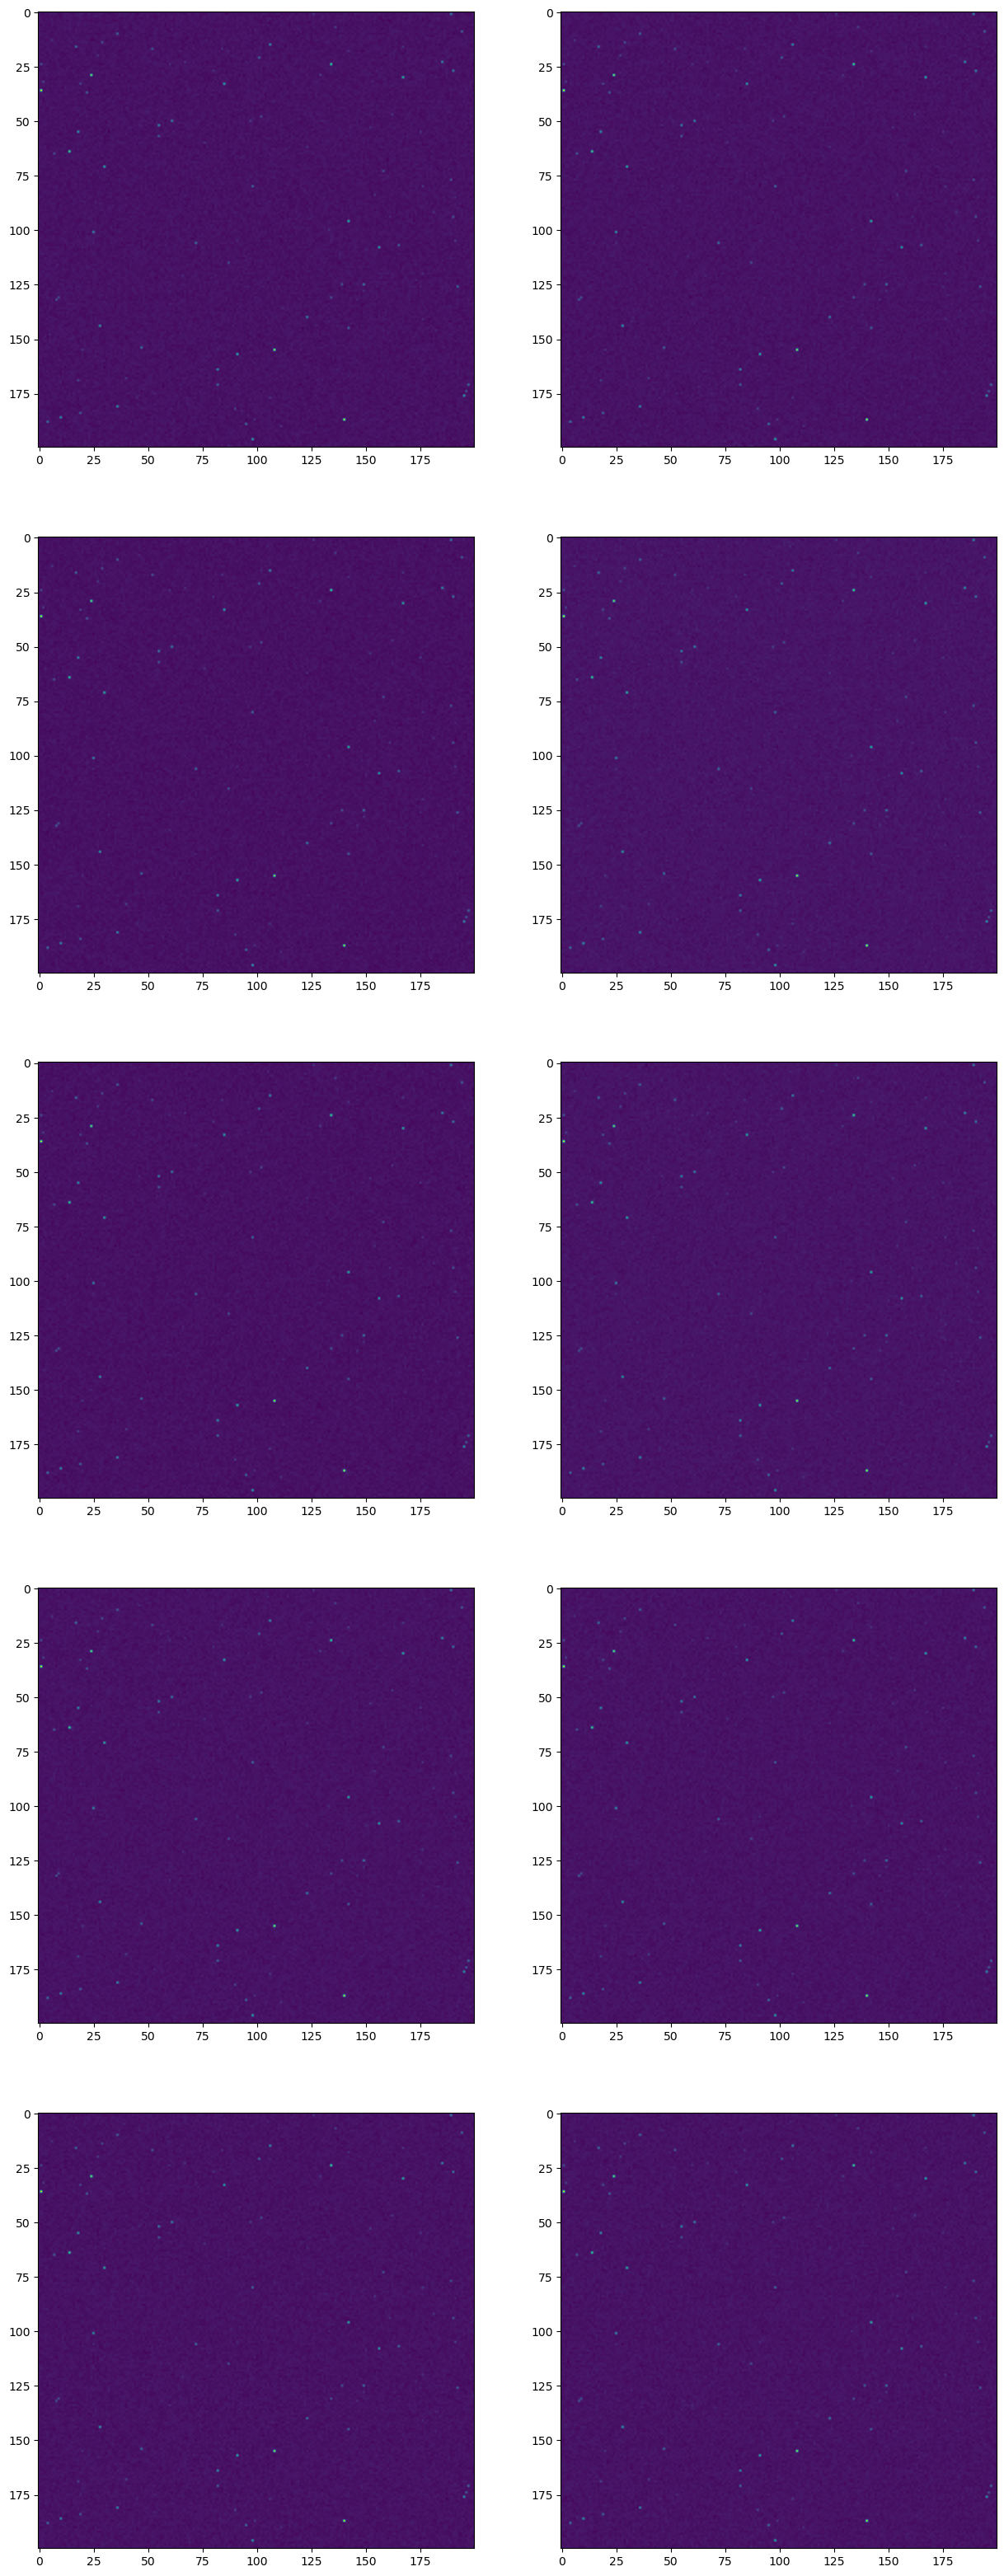

In [24]:
fig, ax = plt.subplots(5,2, figsize = (15,40))
ax[0,0].imshow(img_data[:,:, 0])
ax[0,1].imshow(img_data[:,:, 1])
ax[1,0].imshow(img_data[:,:, 2])
ax[1,1].imshow(img_data[:,:, 3])
ax[2,0].imshow(img_data[:,:, 4])
ax[2,1].imshow(img_data[:,:, 5])
ax[3,0].imshow(img_data[:,:, 6])
ax[3,1].imshow(img_data[:,:, 7])
ax[4,0].imshow(img_data[:,:, 8])
ax[4,1].imshow(img_data[:,:, 9])

In [25]:
stacked = (img_data[:,:, 0] + img_data[:,:, 1] + img_data[:,:, 2] + img_data[:,:, 3] + img_data[:,:, 4] 
               + img_data[:,:, 5] + img_data[:,:, 6] + img_data[:,:, 7] + img_data[:,:, 8] + img_data[:,:, 9])/10 #stacking all 10 images and taking the average

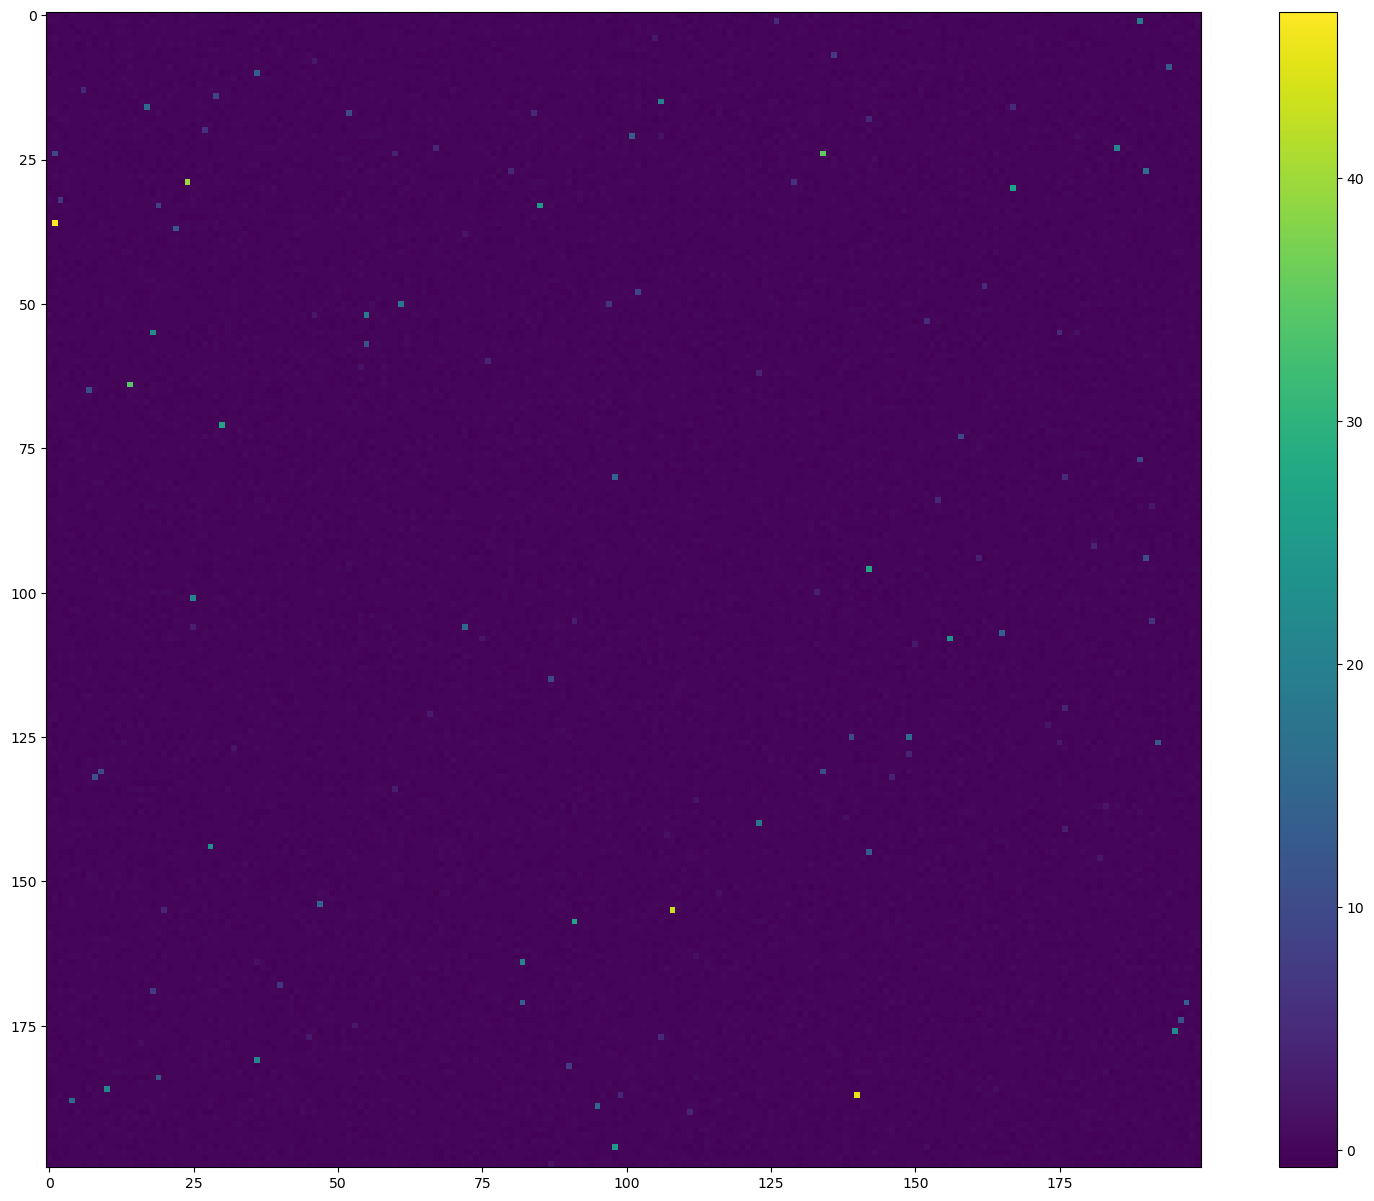

In [26]:
plt.figure(figsize = (20,15))
plt.imshow(stacked)
plt.colorbar()

#### 3) Using your background distribution, hunt for your signal (either faint stars, or a transient). Describe what you find.